In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from math import sqrt
import sys, os
from contextlib import contextmanager
import matplotlib as mpl
import seaborn as sns
import sklearn

In [29]:
df = pd.read_csv('forecasting_data.csv')
df.tail()

,Period,Sales
7,8,10717
8,9,7825
9,10,9693
10,11,15177
11,12,10990


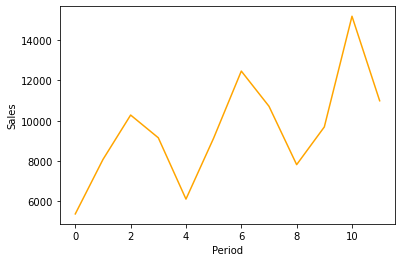

In [9]:
plt.plot(df["Sales"], color = 'orange',label = "Forecasting data")  
plt.xlabel("Period")
plt.ylabel("Sales")
plt.show()

It can be seen from the chart that there is a seasonality, in with a cycle is made of four periods, consisting of low volume of sales in the first period and high volume in the third period. Also, there is a pattern of increasing the sales comparing period to period over time.

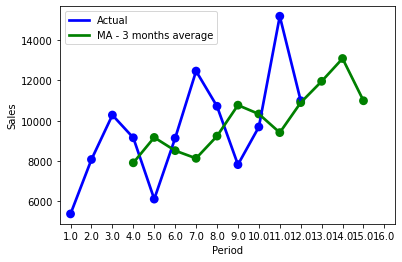

In [22]:
# Moving average 

def moving_average(df,k,to_period): # k is the number 3,as usually the 3 first months are taken as initial points
    MA = pd.DataFrame(columns=["Period","Sales"])
    for i in range(0,to_period):
        if i<k:
            Sale_forecast = float("nan") # it is nan because we need the current initial points to predict
        else:
            history = df["Sales"][i-k:i] # it would be until i+1 but there is how the slice works
            Sale_forecast = history.mean()
        MA.loc[i] = (i+1,Sale_forecast)
    return MA

f, ax = plt.subplots(1, 1)
ma_df = moving_average(df, 3, 16)
sns.pointplot(x='Period', y='Sales', data=df, color='b')
sns.pointplot(x='Period', y='Sales', data=ma_df, color='g')
ax.legend(handles=ax.lines[::len(df)+1], labels=["Actual", "MA - 3 months average"])
plt.show()

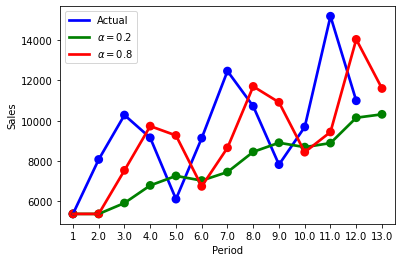

In [62]:
# Exponential smoothing
def exponential_smoothing(df, alpha):
    es_df = pd.DataFrame(columns=['Period','Sales'])
    es_df.loc[0] = [1,df['Sales'][0]] # taking the first value of sales and that's the first point of the prediction
    for i in range (1, len(df)+1):
          sale_forecast = alpha * df["Sales"][i-1] + (1-alpha) * es_df["Sales"][i-1]   # exponential formula. Take the previous value, so that's why exponential    
          es_df.loc[i] = (i+1, sale_forecast)                    
    return es_df

f, ax = plt.subplots(1, 1)
es_df_02 = exponential_smoothing(df, 0.2)
es_df_08 = exponential_smoothing(df, 0.8)
sns.pointplot(ax=ax, x='Period', y='Sales', data=df, color='b')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='g')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_08, color='r')

ax.legend(handles=ax.lines[::len(df)+2], labels=["Actual", r'$\alpha=0.2$', r"$\alpha=0.8$"])
plt.show()

   Seq      I     II    III
0    1   5384   6118   7825
1    2   8081   9139   9693
2    3  10282  12460  15177
3    4   9156  10717  10990
         I     II    III
Seq                     
1     5384   6118   7825
2     8081   9139   9693
3    10282  12460  15177
4     9156  10717  10990
I       8225.75
II      9608.50
III    10921.25
dtype: float64
            I        II       III       Avg
Seq                                        
1    0.654530  0.636728  0.716493  0.669250
2    0.982403  0.951137  0.887536  0.940359
3    1.249977  1.296768  1.389676  1.312141
4    1.113090  1.115367  1.006295  1.078251
Predict the 4th cycle:
12038.807805355975
    Period         Sales
12      13   8056.975955
13      14  11320.795659
14      15  15796.608425
15      16  12980.851183


<ipython-input-72-f98c8ccc7edb>:50: RankWarning: Polyfit may be poorly conditioned
  season_df = predict_with_seasonality(df, [13,14,15,16])


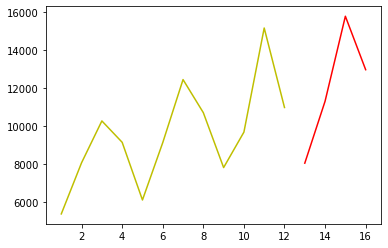

In [72]:
#Seasonality
def get_season(row):
    if row['Period'] >= 5 and row['Period'] <= 8:
        return 'II'
    elif row['Period'] >= 9 and row['Period'] <= 12:
        return 'III'
    else:
        return 'I'
    
def get_seq(row):
    return row['Period']%4 and row['Period']%4 or 4

def predict_with_seasonality(df, months):
    new_df = df.copy()
    new_df['Season'] = new_df.apply(get_season, axis=1) # apply the get season in a new dataframe
    new_df['Seq'] = new_df.apply(get_seq, axis=1) # apply the get seq in the same new dataframe
    
    season_df = pd.DataFrame((new_df.pivot('Seq','Season')['Sales']).to_records())
    print(season_df)
    season_df.index = season_df['Seq'] # indexing the table
    season_df = season_df.drop(['Seq'], axis=1)
    print(season_df)
    
    avg_df = season_df.apply((np.mean), axis=0)
    print(avg_df)

#seasonal index
    seasonal_index_df = pd.DataFrame(columns=['I','II','III'])
    seasonal_index_df['I'] = season_df['I']/avg_df['I']                                     
    seasonal_index_df['II'] = season_df['II']/avg_df['II']
    seasonal_index_df['III'] = season_df['III']/avg_df['III']
    seasonal_index_df['Avg'] = seasonal_index_df.apply((np.mean), axis=1)
    print(seasonal_index_df)   

#using normal forecast
    season = np.array([1,2,3])
    avg_arr = np.array([avg_df['I'], avg_df['II'], avg_df['III']])
    fit = np.polyfit(season, avg_arr, 3)
    poly = np.poly1d(fit) # poly of 1 coeficient so it is a linear regression
    average_predict = poly(4)
    print("Predict the 4th cycle:")
    print(average_predict)
    
    forecast_df = pd.DataFrame(columns=['Period','Sales'])
    forecast_df['Sales'] = seasonal_index_df['Avg']*average_predict
    forecast_df['Period'] = months
    forecast_df.index = np.array(months) - 1
    return forecast_df

season_df = predict_with_seasonality(df, [13,14,15,16])
print(season_df)

f, ax = plt.subplots(1, 1)
plt.plot(df['Period'], df['Sales'], c='y')
plt.plot(season_df['Period'], season_df['Sales'], c='r')
plt.show()

    Period  Sales
0        1   5384
1        2   8081
2        3  10282
3        4   9156
4        5   6118
5        6   9139
6        7  12460
7        8  10717
8        9   7825
9       10   9693
10      11  15177
11      12  10990
12      13   8050
13      14  11300
14      15  15500
15      16  13000


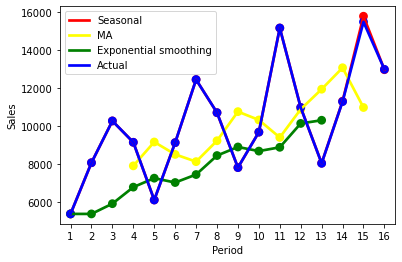

In [73]:
# comparison of forecast
eval_df = pd.read_csv('forecasting_actual.csv')
eval_df = pd.concat([df, eval_df], ignore_index=True)
print(eval_df)
f, ax = plt.subplots(1, 1)
sns.pointplot(ax=ax, x='Period', y='Sales', data=pd.concat([df, season_df], ignore_index=True), color='r')
sns.pointplot(ax=ax, x='Period', y='Sales', data=ma_df, color='yellow')
sns.pointplot(ax=ax, x='Period', y='Sales', data=es_df_02, color='green')
sns.pointplot(ax=ax, x='Period', y='Sales', data=eval_df, color='b')
ax.legend(handles=ax.lines[::len(df)+5], labels=["Seasonal", 'MA', "Exponential smoothing", "Actual"])
plt.show()

In [75]:
#measure of mean absolute deviation errors of the time series
MAD = np.absolute(eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16])
MAD = MAD.mean()
print("MAD of {0}: {1}".format("3-MA", MAD))
MAD_02 = np.absolute(eval_df["Sales"][12:16] - exponential_smoothing(eval_df, 0.2)["Sales"][12:16])
MAD_02 = MAD_02.mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.2", MAD_02))
MAD_08 = np.absolute(eval_df["Sales"][12:16] - exponential_smoothing(eval_df, 0.8)["Sales"][12:16])
MAD_08 = MAD_08.mean()
print("MAD of {0}: {1}".format("Exponential smoothing with alpha=0.8", MAD_08))
MAD_seas = np.absolute(eval_df["Sales"][12:16] - predict_with_seasonality(df,[13,14,15,16])["Sales"])
MAD_seas = MAD_seas.mean()
print("MAD of {0}: {1}".format("Seasonality Method", MAD_seas))

MAD of 3-MA: 2694.75
MAD of Exponential smoothing with alpha=0.2: 2707.7580143305513
MAD of Exponential smoothing with alpha=0.8: 3088.7232615120074
   Seq      I     II    III
0    1   5384   6118   7825
1    2   8081   9139   9693
2    3  10282  12460  15177
3    4   9156  10717  10990
         I     II    III
Seq                     
1     5384   6118   7825
2     8081   9139   9693
3    10282  12460  15177
4     9156  10717  10990
I       8225.75
II      9608.50
III    10921.25
dtype: float64
            I        II       III       Avg
Seq                                        
1    0.654530  0.636728  0.716493  0.669250
2    0.982403  0.951137  0.887536  0.940359
3    1.249977  1.296768  1.389676  1.312141
4    1.113090  1.115367  1.006295  1.078251
Predict the 4th cycle:
12038.807805355975
MAD of Seasonality Method: 85.88221407247443


<ipython-input-75-aa06f6489813>:11: RankWarning: Polyfit may be poorly conditioned
  MAD_seas = np.absolute(eval_df["Sales"][12:16] - predict_with_seasonality(df,[13,14,15,16])["Sales"])


In [80]:
#measure of root mean square errors of the time series
MSE = (eval_df["Sales"][12:16] - moving_average(eval_df, 3, 16)["Sales"][12:16])**2
MSE = sqrt(MSE.mean())
print("MSE of {0}: {1}".format("3-MA", MSE))
MSE_02 = (eval_df["Sales"][12:16] - exponential_smoothing(eval_df, 0.2)["Sales"][12:16])**2
MSE_02 = sqrt(MSE_02.mean())
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.2", MSE_02))
MSE_08 = (eval_df["Sales"][12:16] - exponential_smoothing(eval_df, 0.8)["Sales"][12:16])**2
MSE_08 = sqrt(MSE_08.mean())
print("MSE of {0}: {1}".format("Exponential smoothing with alpha=0.8", MSE_08))
MSE_seas = (eval_df["Sales"][12:16] - predict_with_seasonality(df,[13,14,15,16])["Sales"])**2
MSE_seas = sqrt(MSE_seas.mean())
print("MAD of {0}: {1}".format("Seasonality Method", MSE_seas))


MSE of 3-MA: 3397.6817627775426
MSE of Exponential smoothing with alpha=0.2: 3121.5467755363425
MSE of Exponential smoothing with alpha=0.8: 3302.905190104824
   Seq      I     II    III
0    1   5384   6118   7825
1    2   8081   9139   9693
2    3  10282  12460  15177
3    4   9156  10717  10990
         I     II    III
Seq                     
1     5384   6118   7825
2     8081   9139   9693
3    10282  12460  15177
4     9156  10717  10990
I       8225.75
II      9608.50
III    10921.25
dtype: float64
            I        II       III       Avg
Seq                                        
1    0.654530  0.636728  0.716493  0.669250
2    0.982403  0.951137  0.887536  0.940359
3    1.249977  1.296768  1.389676  1.312141
4    1.113090  1.115367  1.006295  1.078251
Predict the 4th cycle:
12038.807805355975
MAD of Seasonality Method: 149.01707837131843


<ipython-input-80-8e62b91d85a1>:11: RankWarning: Polyfit may be poorly conditioned
  MSE_seas = (eval_df["Sales"][12:16] - predict_with_seasonality(df,[13,14,15,16])["Sales"])**2


Comparing the two metrics of error, although there is a slightly difference in the level of errors for each time series, both metrics of error indicate that the seasonality method has the minimum error compared with the actual values, indicating that it is the better fit for the time series.